In [1]:
import matplotlib.pyplot as plt
import librosa
import torchaudio
import numpy as np
import torch
import torchyin
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import soundfile as sf

import src.utils as utils
import src.models as models
import src.spectrograms as spec
import src.init as init

eps = 1e-6

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Load the ground truth dataset

In [2]:
dataset_name    = "dataset"
dataset         = utils.MaestroNMFDataset(f"{dataset_name}/audios", f"{dataset_name}/midis", fixed_length=False, use_H=False, num_files=None)
train_size      = 0.8

train_set, valid_set = torch.utils.data.random_split(dataset, [train_size, 1-train_size])

train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=1, shuffle=False)

### Create the model
`hidden`=`8`, `shared`=`True` => 1122 params

In [3]:
W_path = 'test-data/single-notes-2'
ralmu = models.RALMU(l=88, beta=1, W_path=W_path, n_iter=5, n_init_steps=1, hidden=8, shared=True, return_layers=False)
utils.model_infos(ralmu, names=False)
ralmu

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


The model has 1122 parameters


RALMU(
  (layers): ModuleList(
    (0-4): 5 x RALMU_block(
      (Aw): Aw_cnn(
        (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01)
        (softplus): Softplus(beta=1.0, threshold=20.0)
      )
      (Ah): Ah_cnn(
        (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(8, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1

### Train the model

In [4]:
def train(model, loader, optimizer, criterion, device, epochs, valid_loader=None):
    train_losses, valid_losses = [], []
    
    for epoch in range(epochs):
        
        train_loss, valid_loss = 0, 0
        
        model.train()
        for M, H in loader:
            
            model.init_H(M[0])
            M = M.to(device)
            H = H.to(device)
            
            W_hat, H_hat, _ = model(M)
            
            H_hat_r = utils.soft_permutation_match(H_hat, model.H0, rows=True)
            
            optimizer.zero_grad()
            loss = criterion(H_hat_r, H[0])
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(loader)
        train_losses.append(train_loss)
        print(f"epoch {epoch}, loss = {train_losses[epoch]:5f}")
    
        if valid_loader is not None:
        
            model.eval()
            for M, H in valid_loader:
                model.init_H(M[0])
                M = M.to(device)
                H = H.to(device)
                
                with torch.no_grad():
                    W_hat, H_hat, _ = model(M)
                
                H_hat_r = utils.soft_permutation_match(H_hat, model.H0, rows=True)
                loss = criterion(H_hat_r, H[0])
                valid_loss += loss.item()
            
            valid_loss /= len(valid_loader)
            valid_losses.append(valid_loss)
    
    return train_losses, valid_losses, W_hat, H_hat

In [5]:
def midi_train(model, loader, optimizer, criterion, device, epochs):
    losses = []
    
    for epoch in range(epochs):
        
        epoch_loss = 0
        
        for M, midi_gt in loader:
            
            model.init_H(M[0])
            M = M.to(device)
            midi_gt = midi_gt[0].to(device)
            
            W_hat, H_hat, _ = model(M)
            
            _, notes_pred = init.W_to_pitch(W_hat, model.freqs, use_max=True)
            midi_pred, active_pred = init.WH_to_MIDI(W_hat, H_hat, notes_pred, threshold=0.05)

            active_gt = [i for i in range(88) if (midi_gt[i,:] > 0).any().item()]
            active = list(set(active_gt + active_pred))
            
            optimizer.zero_grad()
            loss = criterion(midi_pred[active,:], midi_gt[active,:])
    
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.detach()
        losses.append(epoch_loss/ loader.__len__())
        print(f"epoch {epoch}, loss = {losses[epoch]:5f}")
    
    return losses, W_hat, H_hat

In [6]:
def warmup_train(model, n_epochs, loader, optimizer, device, debug=False):
    losses = []
    H1 = None
    for i in range(n_epochs):
        train_loss = 0
        for idx, (M, _) in enumerate(loader):
            model.init_H(M[0])
            if i == 0 and idx==6:
                H1 = ralmu.H0
            M = M.to(device)
            W_hat, H_hat, _ = model(M)
            
            # if i==5 and idx==5:
            #     spec.vis_cqt_spectrogram(W_hat.detach(), np.arange(W_hat.shape[1]), np.arange(W_hat.shape[0]), 0, W_hat.shape[1], title="Aw(W) with line permuted W")
            #     W_hat_r = utils.soft_permutation_match(W_hat, model.W0)
            #     # H_hat_r = utils.soft_permutation_match(H_hat, model.H0, rows=True)
            #     spec.vis_cqt_spectrogram(W_hat_r.detach(), np.arange(W_hat.shape[1]), np.arange(W_hat.shape[0]), 0, W_hat.shape[1], title="rearranged Aw(W)")
            # else:
            W_hat_r = utils.soft_permutation_match(W_hat, model.W0)
            H_hat_r = utils.soft_permutation_match(H_hat, model.H0, rows=True)
            
            ground_truth_norm = torch.norm(model.W0) + torch.norm(model.H0)
            train_loss += torch.norm(model.W0 - W_hat_r) + torch.norm(model.H0 - H_hat_r)
            
            optimizer.zero_grad()
            train_loss.backward()
                    
            optimizer.step()
            train_loss = train_loss.item() / ground_truth_norm * 100
        losses.append(train_loss/ len(loader))
        print(f"------- epoch {i}, loss = {losses[i]:.3f} -------")
    if debug:
        plt.plot(losses, label='Reconstruction of W + H loss over epochs')
        plt.xlabel('epochs')
        plt.show()
        
    spec.vis_cqt_spectrogram(W_hat.detach(), np.arange(W_hat.shape[1]), np.arange(W_hat.shape[0]), 0, W_hat.shape[1], title="Aw(W) with line permuted W")
    spec.vis_cqt_spectrogram(W_hat_r.detach(), np.arange(W_hat_r.shape[1]), np.arange(W_hat_r.shape[0]), 0, W_hat_r.shape[1], title="rearranged Aw(W)")
    
    return losses, W_hat, H_hat, H1

------- epoch 0, loss = 18.967 -------
------- epoch 1, loss = 15.153 -------
------- epoch 2, loss = 15.118 -------
------- epoch 3, loss = 14.666 -------
------- epoch 4, loss = 14.444 -------
------- epoch 5, loss = 14.426 -------
------- epoch 6, loss = 14.240 -------
------- epoch 7, loss = 14.274 -------
------- epoch 8, loss = 14.222 -------
------- epoch 9, loss = 14.048 -------


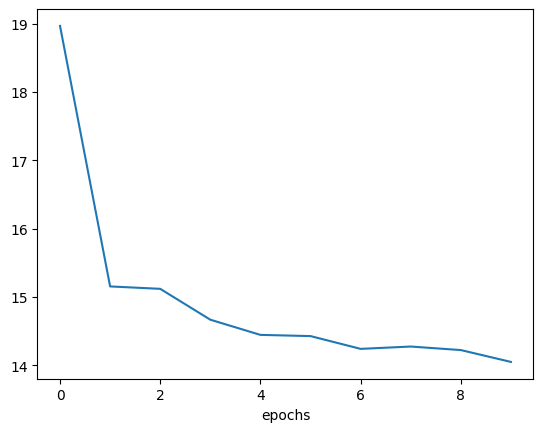

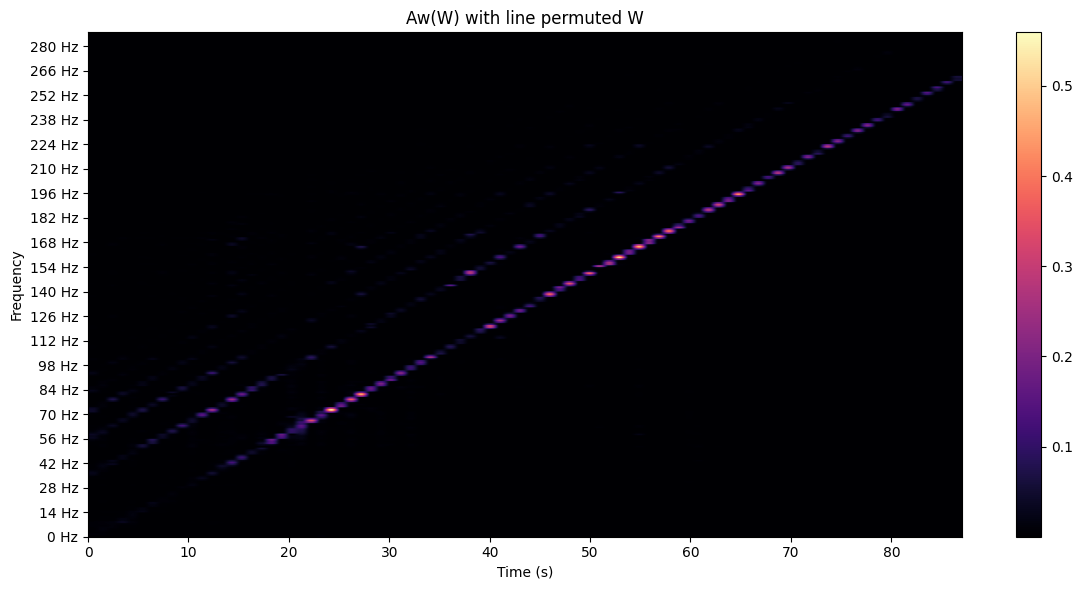

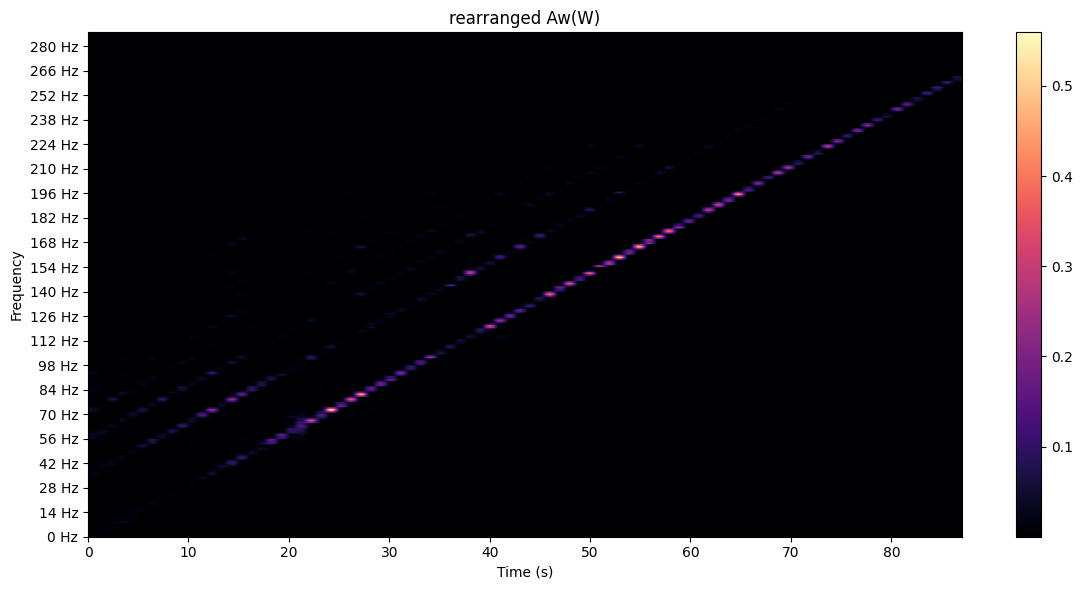

epoch 0, loss = 0.045185
epoch 1, loss = 0.022202
epoch 2, loss = 0.023494
epoch 3, loss = 0.023684
epoch 4, loss = 0.023316
epoch 5, loss = 0.022576
epoch 6, loss = 0.021627
epoch 7, loss = 0.055546
epoch 8, loss = 0.021935
epoch 9, loss = 0.023317
epoch 10, loss = 0.023886
epoch 11, loss = 0.023976
epoch 12, loss = 0.023752
epoch 13, loss = 0.023453
epoch 14, loss = 0.023046
epoch 15, loss = 0.022608
epoch 16, loss = 0.022181
epoch 17, loss = 0.021861
epoch 18, loss = 0.021521
epoch 19, loss = 0.021362


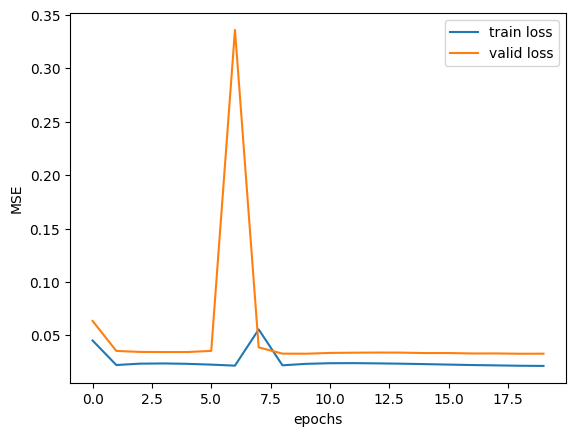

In [7]:
optimizer   = torch.optim.AdamW(ralmu.parameters(), lr=1e-2)
criterion   = nn.MSELoss()
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ralmu.to(device)
epochs      = 20

train1 = False
n_epochs1 = 10
optimizer1 = torch.optim.AdamW(ralmu.parameters(), lr=1e-2)

losses, W_warmup, H_warmup, H1 = warmup_train(ralmu, n_epochs1, train_loader, optimizer1, device, debug=True)

losses, valid_losses, W_hat, H_hat = train(ralmu, train_loader, optimizer, criterion, device, epochs, valid_loader)

# spec.vis_cqt_spectrogram(ralmu.W0, np.arange(ralmu.W0.shape[1]), np.arange(ralmu.W0.shape[0]), 0, ralmu.W0.shape[1])
# spec.vis_cqt_spectrogram(W_warmup.detach(), np.arange(W_warmup.shape[1]), np.arange(W_warmup.shape[0]), 0, W_warmup.shape[1])
# spec.vis_cqt_spectrogram(W_hat.detach(), np.arange(W_hat.shape[1]), np.arange(W_hat.shape[0]), 0, W_hat.shape[1])

plt.plot(losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.ylabel("MSE")
plt.xlabel("epochs")
plt.legend()

In [ ]:
y, sr = torchaudio.load("dataset/audios/example-6.wav")
M, times, _ = spec.cqt_spec(y, sr, hop_length=128)
midi, _, _, _ = spec.midi_to_pianoroll("dataset/midis/example-6.mid", y, times,128,sr)

W_hat, H_hat, M_hat, midi_hat, active_midi = utils.transribe(ralmu, M, device)

In [ ]:
print(utils.compute_metrics(H_hat, midi))

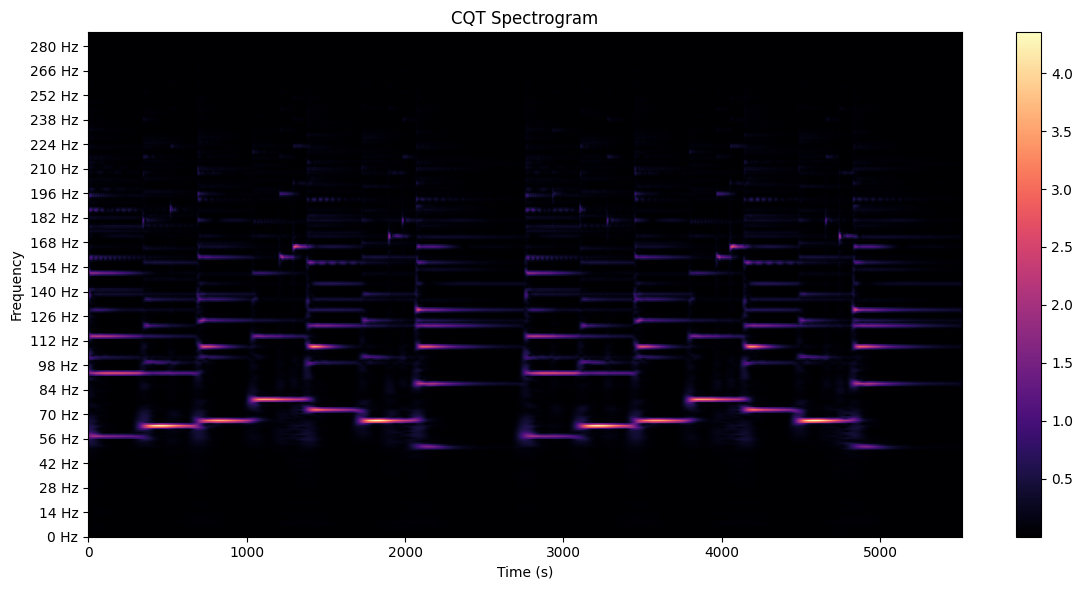

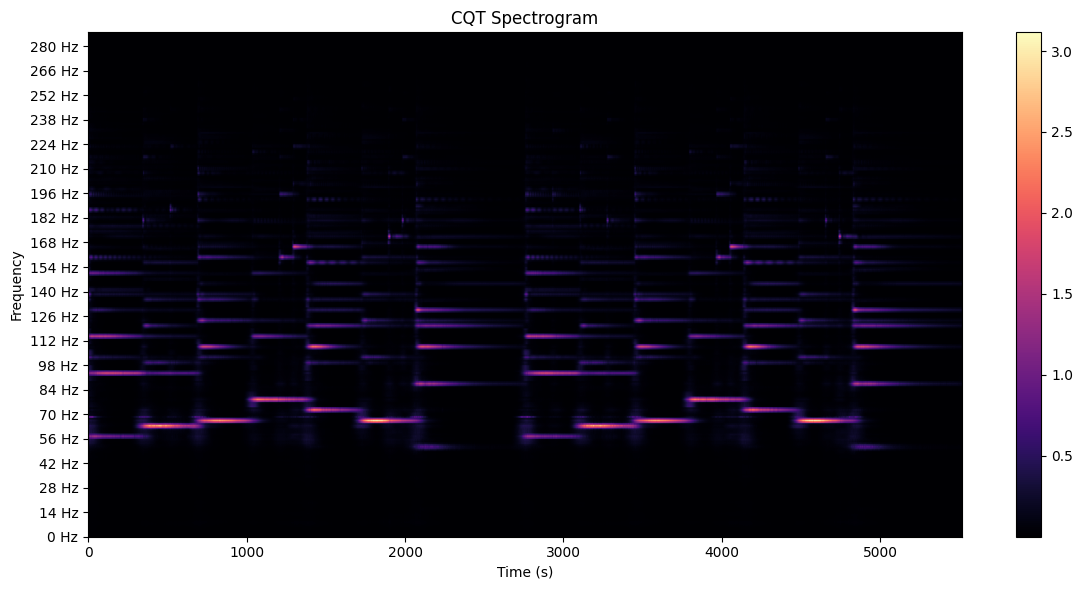

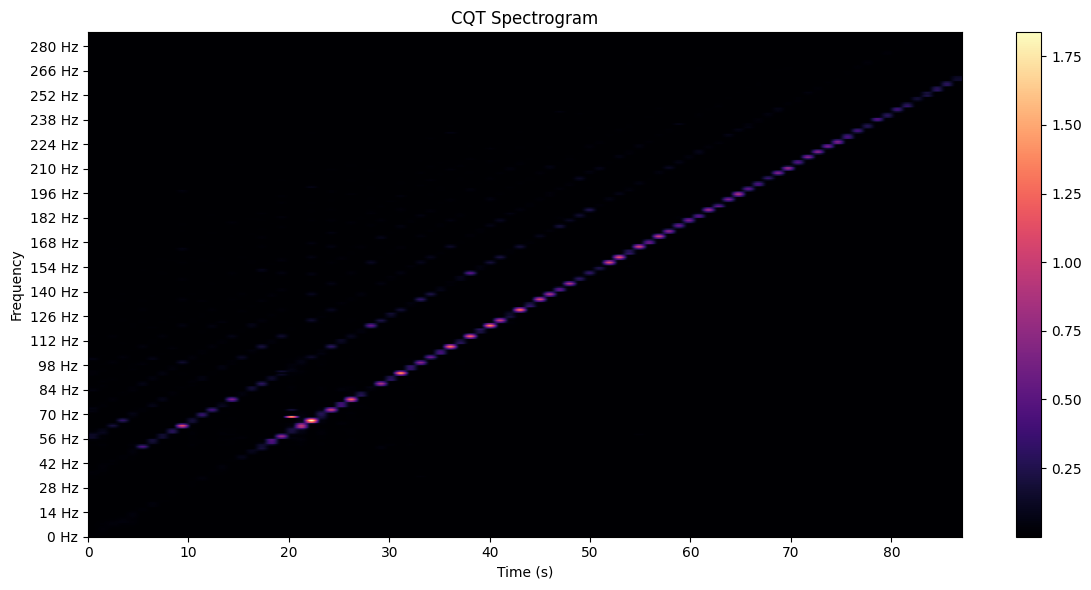

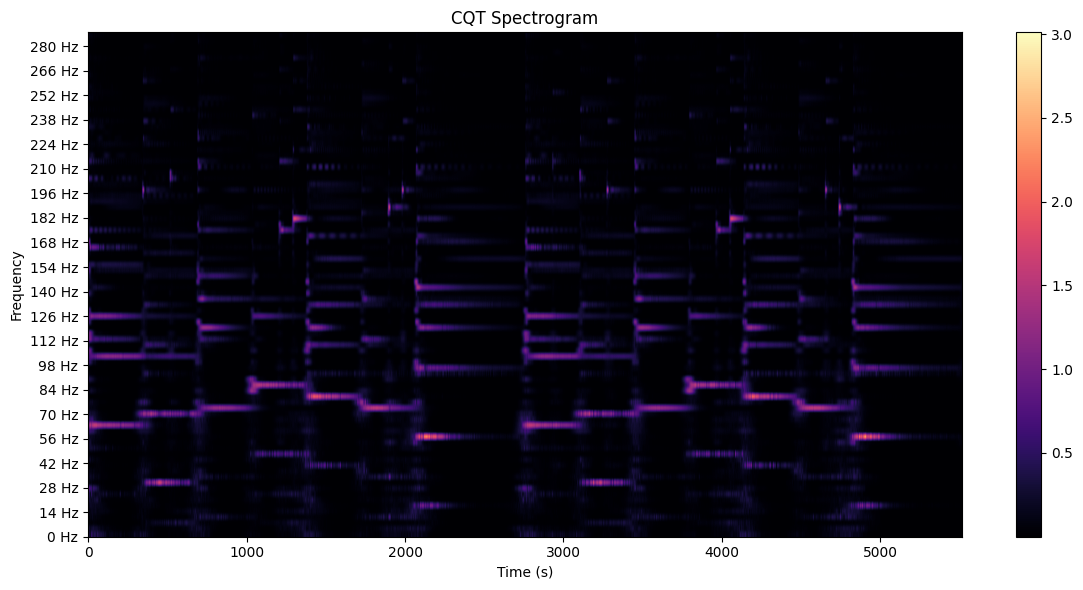

In [33]:
times = np.arange(M.shape[1])
freqs = np.arange(M.shape[0])

spec.vis_cqt_spectrogram(M, times, freqs, 0, times[-1])#, title="Original audio")
spec.vis_cqt_spectrogram(M_hat, times, freqs, 0, times[-1])#, title="Recreated audio")
spec.vis_cqt_spectrogram(W_hat, np.arange(88), freqs, 0, 88)
spec.vis_cqt_spectrogram(H_hat, times, freqs, 0, times[-1])

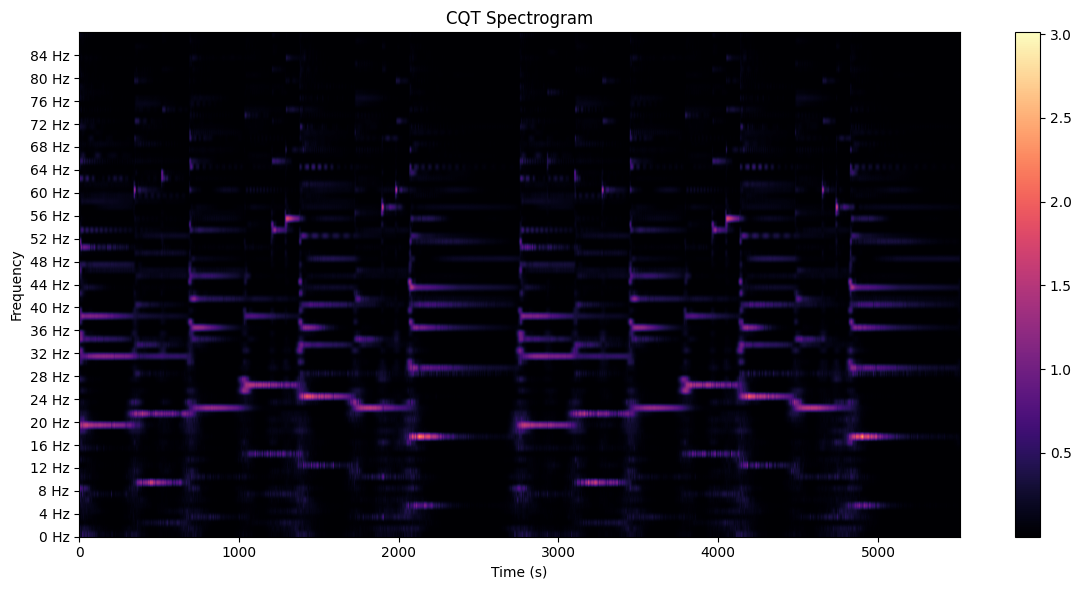

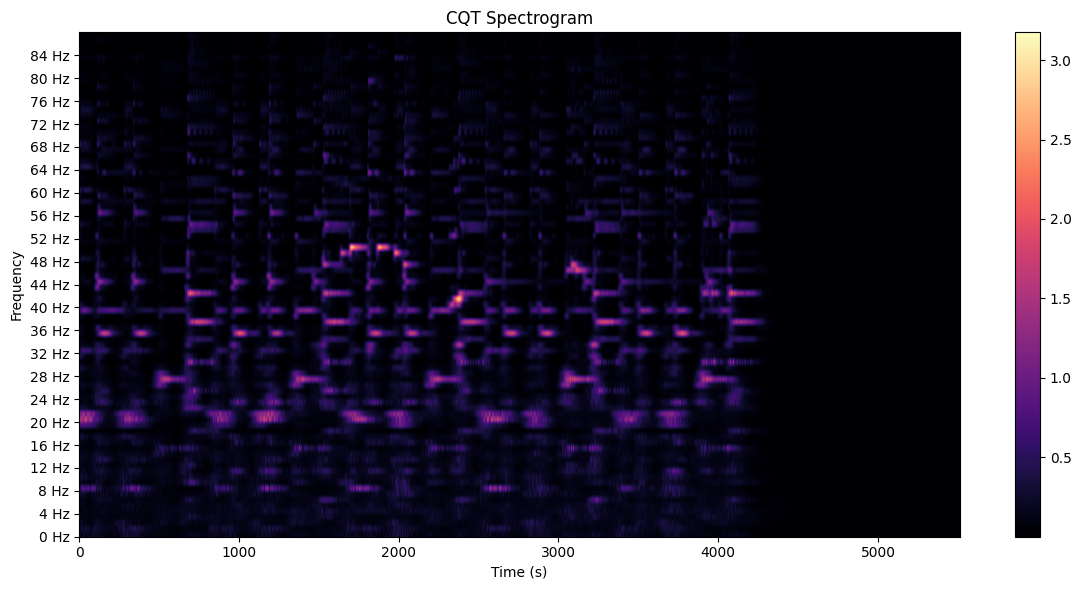

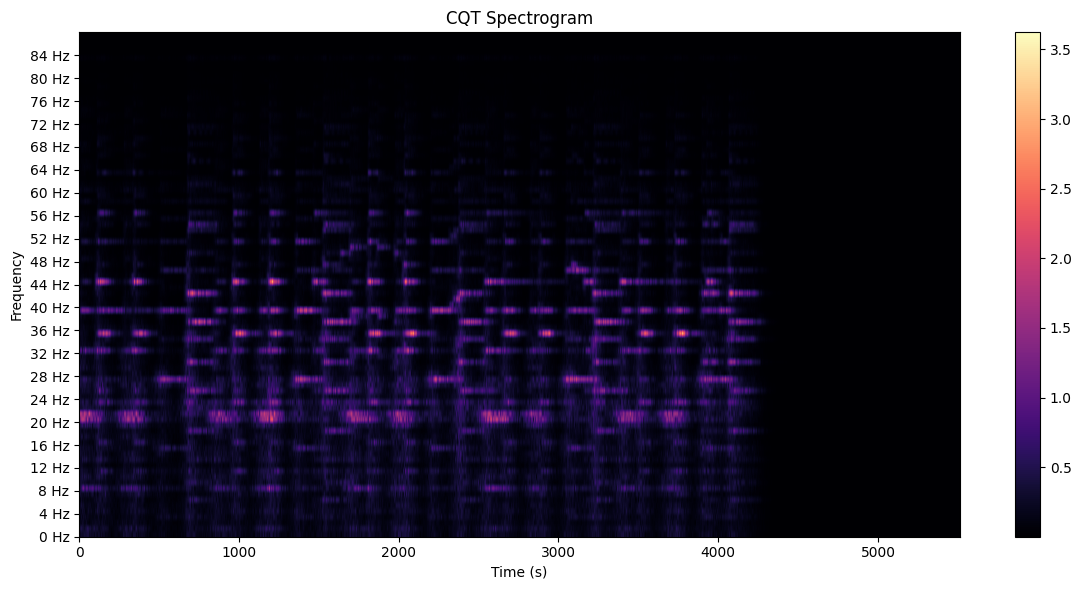

In [34]:
times = np.arange(H_hat.shape[1])
freqs = np.arange(H_hat.shape[0])

spec.vis_cqt_spectrogram(H_hat.detach(), times, freqs, 0, times[-1])
spec.vis_cqt_spectrogram(H_warmup.detach(), times, freqs, 0, times[-1])
spec.vis_cqt_spectrogram(H1, times, freqs, 0, times[-1])
# spec.vis_cqt_spectrogram((torch.abs(H1-H_warmup.detach())), times, freqs, 0, times[-1])
# spec.vis_cqt_spectrogram((torch.abs(H_warmup.detach()-H_hat.detach())), times, freqs, 0, times[-1])